In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MOT_TR import MOT
from Utils import *
import os
from open3d.web_visualizer import draw

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [126]:
params = {
    'd':1,
    'thred_s':0.3,
    'N':20,
    'delta_thred' : 1e-3,
    'step':0.1,
    'win_size':(5,13),
    'eps': 1.6,
    'min_samples':15,
    'missing_thred':60,
    'ending_frame' : 17950,
    'background_update_frame':2000,
    'save_pcd' : 'Unfiltered',
    'save_Azimuth_Laser_info' : False,
    'result_type':'merged'

}

input_path = '../RawLidarData/McCarranEvans_Train/'
dir_lis = os.listdir(input_path)
pcap_path = 'None'
for f in dir_lis:
    if 'pcap' in f.split('.'):
        pcap_path = os.path.join(input_path,f)
if pcap_path == 'None':
    print('Pcap file is not detected')
output_file_path = '../RawLidarData/McCarranEvans_Train/'
config_path = os.path.join(input_path,'config.json')
ref_LLH_path,ref_xyz_path = os.path.join(input_path,'LLE_ref.csv'),os.path.join(input_path,'xyz_ref.csv')
ref_LLH,ref_xyz = np.array(pd.read_csv(ref_LLH_path)),np.array(pd.read_csv(ref_xyz_path))
ref_LLH[:,[0,1]] = ref_LLH[:,[0,1]] * np.pi/180
ref_LLH[:,2] = ref_LLH[:,2]/3.2808

mot = MOT(pcap_path,output_file_path,**params)
mot.initialization()
mot.mot_tracking(A,P,H,Q,R)

Initialization...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:58<00:00, 16.92it/s]


Generating Threshold Map


Tracking 2000 frame:  11%|██████▏                                                 | 1999/17949 [03:40<32:27,  8.19it/s]

Generating Threshold Map


Tracking 4000 frame:  22%|████████████▍                                           | 3999/17949 [07:37<28:01,  8.30it/s]

Generating Threshold Map


Tracking 6000 frame:  33%|██████████████████▋                                     | 5999/17949 [11:30<23:25,  8.50it/s]

Generating Threshold Map


Tracking 8000 frame:  45%|████████████████████████▉                               | 7999/17949 [15:24<19:38,  8.45it/s]

Generating Threshold Map


Tracking 10000 frame:  56%|██████████████████████████████▋                        | 9999/17949 [19:15<17:45,  7.46it/s]

Generating Threshold Map


Tracking 12000 frame:  67%|████████████████████████████████████                  | 11999/17949 [23:03<11:48,  8.40it/s]

Generating Threshold Map


Tracking 14000 frame:  78%|██████████████████████████████████████████            | 13999/17949 [26:51<07:20,  8.97it/s]

Generating Threshold Map


Tracking 14551 frame:  81%|███████████████████████████████████████████▊          | 14550/17949 [27:58<06:32,  8.67it/s]


KeyboardInterrupt: 

In [127]:
Q = np.diag([1,1,0.1,0.1,0.001,0.001])
R = np.diag([10,10])
P_em = np.diag([10,10,0.1,0.1,0.001,0.001])
P_em = np.full((2,P_em.shape[0],P_em.shape[1]),P_em)


In [128]:
def evaluate(key,P_em,R,Q):
    ind = key
    traj_mea = mot.Off_tracking_pool[ind].mea_seq
#     traj_mea = []
#     for i,s in enumerate(traj_mea_):
#         if type(s) != int:
#             traj_mea.append(s)
#     traj_mea = np.array(traj_mea)
    traj_post = mot.Off_tracking_pool[ind].post_seq
    traj_post = np.array(traj_post,dtype=object)
    mea_init = traj_mea[0]
    n_repr = mea_init.shape[0]
    n_offset_dim = A.shape[0] - mea_init.shape[1]
    state_init = np.concatenate([mea_init.reshape(-1,n_repr,2,1),np.zeros((1,n_repr,n_offset_dim,1))],axis = 2)
    state_cur = state_init
    # P_em = np.full((2,P_em.shape[0],P_em.shape[1]),P_em)
    P_init = P_em.copy()
    P_cur = P_init
    total_loss = []
    his_state_pred,his_P_pred = [],[]
    his_state_est,his_P_est = [],[]

    for i in range(len(traj_mea)):
        mea_next = traj_mea[i]
        if type(mea_next) != int:
            state_pred,P_pred = state_predict(A,Q,state_cur,P_cur)
            total_loss.append(np.sqrt(np.sum((mea_next - state_pred[:,:,:2]))**2))
            state_cur,P_cur = state_update(A,H,state_pred,P_pred,R,mea_next)
            his_state_pred.append(state_pred[0])
            his_P_pred.append(P_pred)
            his_state_est.append(state_cur[0])
            his_P_est.append(P_cur)
        else:
            state_cur,P_cur = state_predict(A,Q,state_cur,P_cur)
            his_state_pred.append(state_cur)
            his_P_pred.append(P_cur)
            his_state_est.append(state_cur)
            his_P_est.append(P_cur)
    his_state_pred,his_P_pred = np.array(his_state_pred,dtype=object),np.array(his_P_pred,dtype=object)
    his_state_est,his_P_est = np.array(his_state_est,dtype=object),np.array(his_P_est,dtype=object)
    
    return np.mean(total_loss),his_state_pred,traj_mea

In [129]:
Q = np.diag([1,1,0.1,0.1,0.001,0.001])
R = np.diag([0.01,0.01])
P_em = np.diag([0.1,0.1,0.3,0.3,0.01,0.01])
P_em = np.full((2,P_em.shape[0],P_em.shape[1]),P_em)

In [136]:
mot.Off_tracking_pool.keys()

dict_keys([1, 11, 36, 78, 84, 80, 81, 82, 83, 79, 92, 88, 89, 94, 95, 103, 102, 111, 110, 113, 117, 104, 120, 121, 115, 123, 124, 122, 128, 116, 125, 139, 129, 131, 135, 134, 137, 146, 142, 132, 143, 136, 141, 147, 148, 149, 155, 150, 159, 160, 158, 165, 167, 182, 178, 166, 180, 184, 188, 192, 181, 170, 183, 190, 195, 196, 211, 179, 302, 303, 197, 198, 305, 308, 339, 336, 338, 312, 341, 342, 340, 344, 345, 348, 349, 351, 362, 347, 363, 346, 350, 364, 369, 370, 368, 367, 372, 383, 376, 373, 400, 371, 410, 405, 404, 425, 413, 414, 416, 421, 412, 408, 409, 429, 430, 418, 544, 611, 639, 644, 640, 601, 641, 527, 615, 646, 642, 643, 1082, 1086, 651, 805, 1091, 1093, 1087, 1108, 1088, 1110, 1098, 1105, 1111, 1109, 1114, 1112, 1118, 1116, 1119, 1104, 1126, 1128, 1124, 1123, 1171, 1172, 1129, 1125, 1297, 1234, 1253, 1106, 1328, 1278, 1285, 1339, 1318, 1173, 1191, 1195, 1332, 1336, 1349, 1340, 1342, 1341, 1344, 1353, 1350, 1352, 1354, 1358, 1343, 1363, 1369, 1371, 1368, 1374, 1372, 1375, 1397, 1

0.6895685862194836


(array([519.,  13.,   4.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([ 0.        ,  1.85340234,  3.70680467,  5.56020701,  7.41360934,
         9.26701168, 11.12041401, 12.97381635, 14.82721868, 16.68062102,
        18.53402335]),
 <BarContainer object of 10 artists>)

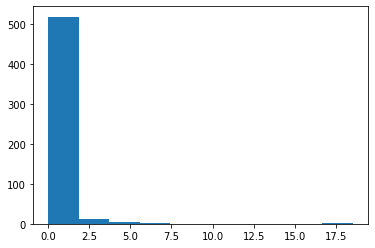

In [130]:
results = []
for key in mot.Off_tracking_pool.keys():
    loss,his_state_pred,traj_mea = evaluate(key,P_em,R,Q)
    results.append(loss)
print(np.mean(results))
plt.hist(results)

In [137]:
loss,his_state_pred,traj_mea = evaluate(1,P_em,R,Q)
plt.figure(figsize=(10,10))
plt.plot(traj_mea[:,0,0],traj_mea[:,0,1],markersize = 10,marker = 'x')
plt.plot(his_state_pred[:,0,0],his_state_pred[:,0,1],marker = 'o',markersize = 3)
plt.plot(traj_mea[:,1,0],traj_mea[:,1,1],markersize = 10,marker = 'x')
plt.plot(his_state_pred[:,1,0],his_state_pred[:,1,1],marker = 'o',markersize = 3)
plt.show()

TypeError: list indices must be integers or slices, not tuple

<Figure size 720x720 with 0 Axes>

In [180]:
post_seq = mot.Off_tracking_pool[1].post_seq
mea_seq = mot.Off_tracking_pool[1].mea_seq
start_frame = mot.Off_tracking_pool[1].start_frame

In [181]:
T = generate_T(ref_LLH,ref_xyz)

In [191]:
temp = np.array(post_seq)
temp = temp.reshape((temp.shape[0],temp.shape[1],temp.shape[2]))
# n x 2 x 6
temp_xy = temp[:,:,:2]
# n x 2 x 2
dis_est = np.sqrt((temp_xy[:,:,0]**2 + temp_xy[:,:,1]**2))
# n x 2 
speed_xy = temp[:,:,2:4] * 10 
# n x 2 x 2
speed = np.sqrt((speed_xy[:,:,0]**2 + speed_xy[:,:,1]**2))*3600/1000
# n x 2
acc_xy = temp[:,:,4:6]
# n x 2
xyz_0 = np.concatenate([temp_xy[:,0],np.zeros(len(temp_xy)).reshape(-1,1)],axis = 1)
xyz_1 = np.concatenate([temp_xy[:,1],np.zeros(len(temp_xy)).reshape(-1,1)],axis = 1)
LLH_est_0 = convert_LLH(xyz_0,T)
LLH_est_1 = convert_LLH(xyz_1,T)
est_0 = np.concatenate([xyz_0,dis_est[:,0].reshape(-1,1),speed_xy[:,0],speed[:,0].reshape(-1,1),acc_xy[:,0],LLH_est_0],axis = 1)
est_1 = np.concatenate([xyz_1,dis_est[:,1].reshape(-1,1),speed_xy[:,1],speed[:,1].reshape(-1,1),acc_xy[:,1],LLH_est_1],axis = 1)
temp = mea_seq
emp_0,emp_1 = [],[]
for i,vec in enumerate(temp):
    if type(vec) == int:
        emp_row = np.empty(2)
        emp_row[:] = np.nan
        emp_0.append(emp_row)
        emp_1.append(emp_row)
    else:
        emp_0.append(vec[0].flatten())
        emp_1.append(vec[1].flatten())
emp_0,emp_1 = np.array(emp_0),np.array(emp_1)
dis_mea_0,dis_mea_1 = np.sqrt(np.sum(emp_0**2,axis = 1)).reshape(-1,1),np.sqrt(np.sum(emp_1**2,axis = 1)).reshape(-1,1)
xyz_0 = np.concatenate([emp_0,np.zeros(len(emp_0)).reshape(-1,1)],axis  = 1)
xyz_1 = np.concatenate([emp_1,np.zeros(len(emp_1)).reshape(-1,1)],axis  = 1)
LLH_est_0 = convert_LLH(xyz_0,T)
LLH_est_1 = convert_LLH(xyz_1,T)
mea_0 = np.concatenate([xyz_0,dis_mea_0,LLH_est_0],axis = 1)
mea_1 = np.concatenate([xyz_1,dis_mea_1,LLH_est_1],axis = 1)
timestp = []
for i in range(len(temp)):
    f = i + start_frame + 1
    timestp.append('%06.0f'%f)
timestp = np.array(timestp).reshape(-1,1)
objid = (np.ones(len(temp)) * key).astype(int).reshape(-1,1)
summary_0 = np.concatenate([objid,timestp,mea_0,est_0],axis = 1)
summary_1 = np.concatenate([objid,timestp,mea_1,est_1],axis = 1)
column_names = ['ObjectID','FrameIndex','Coord_X_Mea','Coord_Y_Mea','Coord_Z_Mea','Distance_Mea','Longitude_Mea','Latitude_Mea',
                'Elevation_Mea','Coord_X_Est','Coord_Y_Est','Coord_Z_Est','Distance_Est','Speed_X','Speed_Y','Speed(m/s)','Acc_X','Acc_Y','Longitude_Est','Latitude_Est','Elevation_Est']
summary_0 = pd.DataFrame(summary_0,columns=column_names)
summary_1 = pd.DataFrame(summary_1,columns=column_names)


In [102]:
xyz = np.concatenate([temp_xy[:,1],np.zeros(len(temp_xy)).reshape(-1,1)],axis = 1)

In [ ]:
temp = np.array(post_seq)
temp = temp.reshape(temp.shape[0],temp.shape[1])[1:-missing_thred] # exclude first and ending data point 
# [0,1,2,3,4,5,6,10,11]
temp_lwhxy = temp[:,[2,3,4,0,1]]
dis_est = np.sqrt(np.sum(temp_lwhxy[:,[3,4]]**2,axis = 1)).reshape(-1,1)
speed_xy = temp[:,[5,6]]*10  #m/s
speed = np.sqrt(np.sum(speed_xy**2,axis = 1)).reshape(-1,1)*3600/1000
#since we don't track the z value, literally use 0 to alternate the z
xyz = np.concatenate([temp_lwhxy[:,[3,4]],np.zeros(temp_lwhxy.shape[0]).reshape(-1,1)],axis = 1) 
LLH_est = convert_LLH(xyz,T)
est = np.concatenate([temp_lwhxy,LLH_est,dis_est,speed_xy,speed],axis = 1)
temp = mea_seq
emp = []
for i,vec in enumerate(temp):
    if type(vec) == int:
        emp_row = np.empty(5)
        emp_row[:] = np.nan
        emp.append(emp_row)
    else:
        emp.append(vec.flatten())
emp = np.array(emp)
emp = emp[1:-missing_thred,[2,3,4,0,1]]
dis_mea = np.sqrt(np.sum(emp[:,[3,4]]**2,axis = 1)).reshape(-1,1)
#since we don't track the z value, literally use 0 to alternate
xyz = np.concatenate([emp[:,[3,4]],np.zeros(emp.shape[0]).reshape(-1,1)],axis = 1) 
LLH_mea = convert_LLH(xyz,T)
mea = np.concatenate([emp,LLH_mea,dis_mea],axis = 1)

timestp = []
for i in range(len(mea)):
    f = i + start_frame + 1
    timestp.append('%06.0f'%f)
timestp = np.array(timestp).reshape(-1,1)
objid = (np.ones(len(mea)) * key).astype(int).reshape(-1,1)
summary = np.concatenate([objid,timestp,mea,est],axis = 1)
summary = pd.DataFrame(summary,columns=col_info+col_mea+col_est)